# CNN for Cifar-10 Dataset

## Requirements

For this project we are used:
* Python 3.6
* Tensorflow 1.8.0
* *GPUs parallel calculation manager* nVidia CUDA 9.0
* *GPU-accelerated library* nVidia cuDNN 7.1
* or CPU optimized tensorflow for intel

## Introduction

In this first notebook we are going to explain how we have set up our work.  
Essentially the process is divided into several parts:
* Set up environment with the Cifar-10 Dataset
* Define a convolutional neural network
* Define a quantization method
* Train the convolutional neural network
* Provide information about CNN's performance and accuracy

In [1]:
import numpy as np
import tensorflow as tf

/home/m/myvenv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Cifar-10 Dataset

Cifar-10 Dataset is taken from the official website www.cs.toronto.edu.

Dataset is stored in the data directory: cnn/data. From Cifar-10 dataset we are going to take x_train, t_train, x_test and t_test.
The training dataset set is used for training the CNN, the testing dataset is used for evaluate the performance and the accuracy of the network.

### Load data

In [2]:
from cnn.dense import dataset_preprocessing_by_keras
from cnn.utils.dataset import load_cifar10

In [3]:
x_train, t_train, x_test, t_test = load_cifar10()

In [4]:
x_train.shape, t_train.shape, x_test.shape, t_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [5]:
x_train = dataset_preprocessing_by_keras(x_train)
x_train[0, :, :, 0]

array([[-0.68747891, -0.65572952, -0.63985482, ..., -0.95734874,
        -1.00497283, -0.92559935],
       [-0.65572952, -0.63985482, -0.59223073, ..., -0.92559935,
        -1.02084753, -0.86210057],
       [-0.7192283 , -0.63985482, -0.65572952, ..., -0.68747891,
        -0.735103  , -0.70335361],
       ...,
       [-0.36998499, -0.7509777 , -1.00497283, ..., -0.25886212,
        -0.24298742, -0.14773924],
       [-0.25886212, -0.65572952, -1.19546919, ...,  0.31262694,
        -0.00486698, -0.49698256],
       [-0.27473681, -0.35411029, -1.11609571, ...,  0.75711843,
         0.64599556,  0.28087755]])

## CNN Model and Training

We will use a custom made wrapper for tensorfllow NN training and use

In [6]:
from cnn.model_class import TfClassifier

This CNN is called *dense_cnn*. Here we will explain how it is composed.

The CNN is composed by several layers. In the first part there are 2 **convolutional** layers and 2 **pooling** layers (they are alternated), then there are a *flatten* layer followed by a **relu** layer, a *dropout* layer and finally a **softmax** layer.

The network uses a stochastic gradient descent optimizer and a categorical crossentropy loss.  
To judge the performance of our model we are used a MSE metric.

In [7]:
from cnn.dense import NET_NAME, eval_fn, forward_pass, loss_fn

In [8]:
model = TfClassifier(NET_NAME, forward_pass, loss_fn, eval_fn,
                     tf.train.AdamOptimizer())

This network is trained for 50 epochs.

In [9]:
history = model.fit(
   [x_train, t_train],
   batch_size=64,
   validation_split=0.1,
   epochs=1,
   verbosity=1)

print(history)

For training: tensorboard --logdir=/tmp/log-tb/dense_cnn/training
For validation: tensorboard --logdir=/tmp/log-tb/dense_cnn/validation
{'logits': (array([[-1.2258677 , -3.6021073 ,  2.8100097 , ..., -0.8590393 ,
        -4.372263  , -3.8334594 ],
       [ 2.4543028 ,  3.422716  , -1.3100829 , ..., -2.0255888 ,
         0.8160184 ,  1.5989125 ],
       [-0.3065187 , -3.2730298 ,  2.007834  , ...,  0.04596729,
        -2.8583841 , -2.3491793 ],
       ...,
       [-1.4331489 , -2.9170594 ,  0.8903945 , ...,  2.2401001 ,
        -4.2348256 , -1.2472872 ],
       [ 1.341874  , -1.9891791 , -0.43798268, ...,  0.37113553,
        -1.6154269 , -1.2536998 ],
       [ 1.2228539 , -1.3998467 ,  0.83702004, ..., -2.7803695 ,
         4.902955  , -0.24045004]], dtype=float32),), 'classes': (array([4, 1, 2, ..., 5, 4, 8]),), 'probabilities': (array([[5.0716787e-03, 4.7115510e-04, 2.8701919e-01, ..., 7.3191929e-03,
        2.1811697e-04, 3.7384286e-04],
       [2.2911222e-01, 6.0342699e-01, 5.31124

Then it's evaluated

In [10]:
evals = model.evaluate([x_test, t_test])

print(evals)

INFO:tensorflow:Restoring parameters from /home/m/Scrivania/aca-tensorflow/cnn/models/dense_cnn/model.ckpt
[{'logits': array([[ 182.26703  ,  -95.602104 ,   61.27622  , ..., -125.16448  ,
          69.58104  ,  -89.89552  ],
       [   8.828863 ,  -82.86985  ,   -1.822132 , ...,  -35.402565 ,
          40.543903 ,  -90.63861  ],
       [ 214.06294  ,  -24.52956  ,   12.136899 , ..., -151.3575   ,
         225.9297   ,   12.841366 ],
       ...,
       [  -7.431719 ,   81.327675 ,  -54.331882 , ...,   -0.8675527,
          42.25553  ,   76.397194 ],
       [  74.825356 ,  191.86877  , -127.94122  , ...,  -38.18188  ,
          77.543785 ,  236.25174  ],
       [  47.4059   ,   43.46117  ,  -14.420177 , ...,  -81.07937  ,
         149.17723  ,   91.89786  ]], dtype=float32), 'classes': array([0, 3, 8, ..., 1, 9, 8]), 'probabilities': array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.7809909e-24, 0.0000000e+00, 6.5846

## Tensorboard Results

Here's a function made by us that plot tags data got from the last tensorboard session

In [11]:
import matplotlib.pyplot as plt
import glob

def plot_from_tensorfboard (param, source):
    files_in_dir = len(glob.glob("/tmp/log-tb/" + NET_NAME + "/" + source + "/*"))
    values = []
    for e in tf.train.summary_iterator(glob.glob("/tmp/log-tb/" + NET_NAME + "/" + source + "/*")[files_in_dir - 1]):
        for v in e.summary.value:
            if v.tag == param:
                values.append(v.simple_value)
    values = np.array(values)
    plt.plot(values)
    plt.show()

Here's **loss** data plot, got from Tensorboard, for *training*:

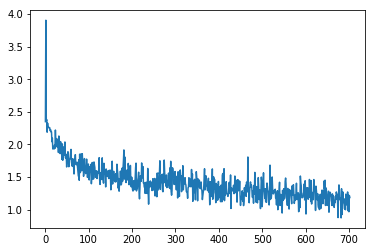

In [12]:
plot_from_tensorfboard('loss','training')

Here's **loss** data plot, got from Tensorboard, for *validation*:

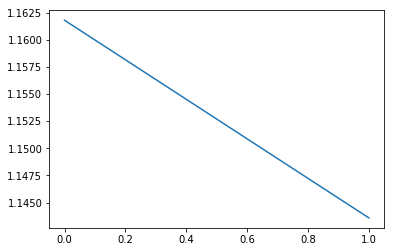

In [13]:
plot_from_tensorfboard('loss','validation')

Here's **mse** data plot, got from Tensorboard, for *training*:

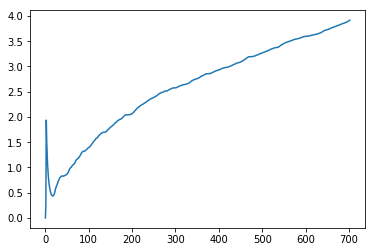

In [14]:
plot_from_tensorfboard('mse','training')

Here's **mse** data plot, got from Tensorboard, for *validation*:

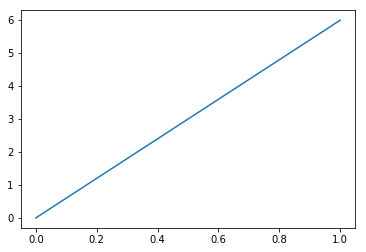

In [15]:
plot_from_tensorfboard('mse','validation')

Here's **accuracy** data plot, got from Tensorboard, for *training*:

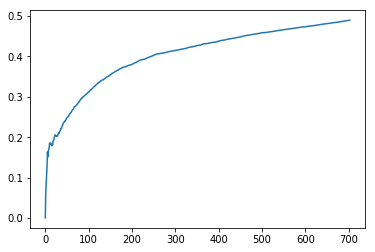

In [16]:
plot_from_tensorfboard('accuracy_1','training')

Here's **accuracy** data plot, got from Tensorboard, for *validation*:

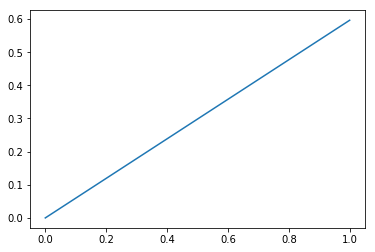

In [17]:
plot_from_tensorfboard('accuracy_1','validation')

### test

In [ ]:
inputs = [x_train, t_train]
input_names = ["features", "labels"]
batch_size = 64
validation_split = 0.2
MAX_BATCH_SIZE = 2000

n_samples = inputs[0].shape[0]

input_tensors = input_names
input_DL = dict(zip(input_tensors, inputs))

input_LD = _split_data_dict_in_perc(input_DL, n_samples,
                                    np.array([1 - validation_split]))

train_dict = input_LD[0]
val_dict = input_LD[1]

n_train_samples = train_dict[input_tensors[0]].shape[0]

train_LD = _batch_data_dict(train_dict, n_train_samples, batch_size)

if n_samples - n_train_samples > MAX_BATCH_SIZE:
    val_LD = _batch_data_dict(val_dict, n_samples - n_train_samples,
                              MAX_BATCH_SIZE)
else:
    val_LD = [val_dict]

train_LD = _set_train_mode_to_LD(train_LD, True)
val_LD = _set_train_mode_to_LD(val_LD, False)